# World CO2 Emissions Forecasting
## ARIMA Model and LSTM Recurren Network Model Forecasting Comparison
[*Cristian Castro Álvarez*](https://github.com/cristian-castro-a)

**Goal**: 
- To compare the performance of an ARIMA Model and a LSTM Recurrent Neural Network model for the forecasting of the WORLD's CO2 Emissions for the next decade


**Data:**
- The data comes from [Our World in Data](https://github.com/owid/co2-data)
- Column 'CO2' of the dataframe indicates the Tonnes of CO2 emmitted into the atmosphere.
- The dataset includes yearly data from 1750 to 2020, with a total of 271 data points.

**Model Selection and Comments:**
- An Autoregressive Integrated Moving Average (ARIMA) Model is an statistical model for times series forecasting. It is autoregressive as its predicts the future values of a time series based on its own past values. For more information and theoretical background, please refer to [Introduction to ARIMA (Duke University)](https://people.duke.edu/~rnau/411arim.htm)
- A Long Short-Term Memory (LSTM) is a Recurrent Neural Network (RNN) which introduce cells that includes self-loops instead of a unit that simply applies an element-wise nonlinearity to the affine transformation of inputs (like the units of regular Neural Networks). For more information and theorical background, please refer to Chapter 10 of [Deep Learning (Goodfellow, Bengio and Courville)](https://www.deeplearningbook.org/)
- For this personal project on a CO2 Emission time series, I chose the ARIMA and LSTM Models as both are widely used for many sequence modeling and time series. While ARIMA is a statistical method, LSTM is booming by hype that Neural Networks are experiencing in industry
- The ARIMA Model and the LSTM Recurrent Neural Network were trained separately, on individual learning processes
- If interested in the individual tranining, please refer in this repository to 'Models' Folder

In [3]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import math

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMAResults
import statsmodels.api as sm
print('Statsmodel Version: ', sm.__version__)

import tensorflow as tf
print('TensorFlow Version: ', tf.__version__)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
import os

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

Statsmodel Version:  0.13.2
TensorFlow Version:  2.0.0


# 1. Data Presentation
- The data comes from [Our World in Data](https://github.com/owid/co2-data)
- Column 'CO2' of the dataframe indicates the Tonnes of CO2 emmitted into the atmosphere.
- The dataset includes yearly data from 1750 to 2020, with a total of 271 data points.

In [4]:
# Raw Data
df = pd.read_csv('Data/owid-co2-data.csv')

# Aggregate the data on a yearly basis (the entire world as one entity, I don't care about the emissions of individual countries)
df = df.groupby(by=['year']).sum().reset_index()[['year','co2']]
df.insert(loc = 1, column = 'month', value = 12)
df.insert(loc = 2, column = 'day', value = 31)
values = pd.to_datetime(df[['year','month','day']])
df.insert(loc = 0, column = 'date', value = values)
df.drop(['year','month','day'], axis = 1, inplace = True)
df.head()

,date,co2
0,1750-12-31,46.755
1,1751-12-31,46.755
2,1752-12-31,46.770
3,1753-12-31,46.770
4,1754-12-31,46.790


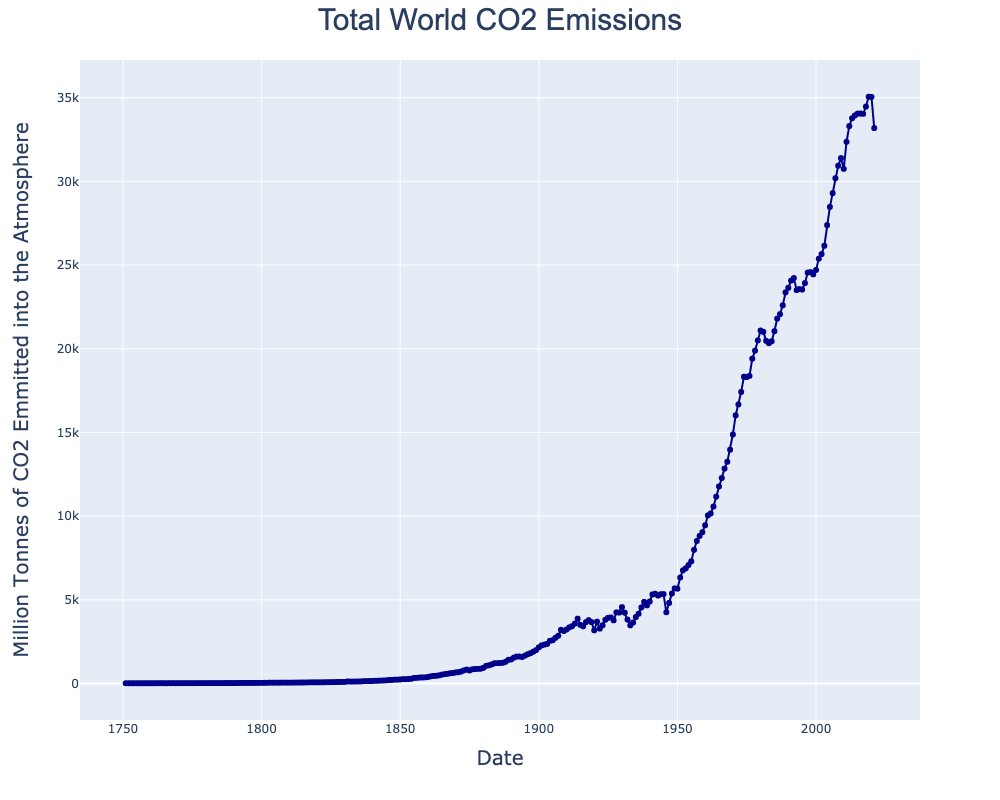

In [5]:
# To work with tonnes of CO2 it is necessary a conversion factor of 3.664.
df['co2'] = df['co2']/3.664

# Visualizing the world emissions per year
fig = px.line(df, 
                x = 'date', 
                y = 'co2', 
                markers = True, 
                height = 800, 
                width = 1000)

fig.update_layout(title = dict(
        text = 'Total World CO2 Emissions',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
    )

fig.update_traces(line_color = 'darkblue')

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Million Tonnes of CO2 Emmitted into the Atmosphere',
    title_font = {'size': 20}
)

fig.show('png')

**Comments:**
- The time series shows worrying trend about CO2 Emissions
- The last point shows an abrupt drop in the CO2 Emissions, this points corresponds to the COVID-19 pandemic effect

# 2. Performance of a LSTM Model
- This sections presents the data preparation (scaling), model import and forecasting for the LSTM Model
- If interested in the training and tuning of the LSTM Model please refer to Models > LSTM_Model.ipynb

## 2.1 Scaling for the Data
- The inputs of the LSTM Model must be between 0 and 1, therefore the MinMaxScaler of SKLearn is used
- The Scaler is trained as it was for the training process of the model

In [6]:
# Reproducing the scale fitting made for training (scaler fitted only on the training data)
df_train = df[:247].copy()
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(df_train['co2'].values.reshape(-1,1))

MinMaxScaler()

In [7]:
# Scaling the Input Data for LSTM Model
df_input_lstm = df.copy()
df_input_lstm['co2'] = scaler.transform(df['co2'].values.reshape(-1,1))
df_input_lstm.tail()

,date,co2
266,2016-12-31,1.386534
267,2017-12-31,1.404320
268,2018-12-31,1.428210
269,2019-12-31,1.427880
270,2020-12-31,1.351911


## 2.2 Import Best LSTM Model
- Model trained by using Random Search and Keras Tuner (Please refer to LSTM_Model.ipynb)
- The model was stored as .h5 format in the path: Models > best_lstm_model_tuned

In [8]:
# Import Best LSTM Model
# Please refer to "Models" Folder to check in detail the training process
directory = 'Models/best_lstm_model_tuned/best_lstm.h5'
parent_dir = os.path.abspath(os.getcwd())
path = os.path.join(parent_dir, directory)
best_lstm = tf.keras.models.load_model(path)

2022-10-10 20:46:51.895934: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 20:46:51.897895: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [9]:
# Architecture of the best LSTM Model
best_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 120)            58560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 95)                82080     
_________________________________________________________________
dense (Dense)                (None, 45)                4320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 46        
Total params: 145,006
Trainable params: 145,006
Non-trainable params: 0
_________________________________________________________________


## 2.3 Forecasting with LSTM Model
- The goal is to forecast the next 10 years (starting 2021) using the previously trained LSTM Model 
- For that 10 different sequences must be created, as the models accept sequences of data as input
- As each entry will be subsequently be used for forecasting, this can be done in a for loop

In [10]:
# Forecasting: 10 iterations (from 2021 to 2030)

# Sequences 
# The model starts at the end of its testing (Refer to LSTM_Model.ipynb)
X_forecast = [[[1.4044411],[1.4052532],[1.4258372],[1.4443076],[1.436478]]]
X_forecast = np.array(X_forecast)

# List of predictions
predictions = []

for iteration in range(1,11):
    # Get prediction for this iteration
    prediction = best_lstm.predict(X_forecast)
    predictions.append(prediction[-1])

    # Append the prediction and update the next sequence
    to_append = X_forecast.tolist()
    to_append = to_append[iteration-1][-4:]
    to_append.append([prediction[-1][0]])
    X_forecast = X_forecast.tolist()
    X_forecast.append(to_append)
    X_forecast = np.array(X_forecast)

In [11]:
# Re Scale Predictions
scaled_predictions = scaler.inverse_transform(predictions)
scaled_predictions.reshape(-1)

array([35438.04465442, 35817.66402361, 36139.76335646, 36382.41284661,
       36566.8139395 , 36729.19162141, 36889.49245091, 37043.35503794,
       37182.57142775, 37305.07354338])

In [12]:
# Creating a Dataframe for Forecasting
forecast = pd.DataFrame(
    {
        'date': pd.date_range(
            start = '2021-12-31',
            end = '2030-12-31',
            freq = 'Y'
            ), 
        'co2_forecasted': scaled_predictions.reshape(-1)
    }
)
forecast.head()

,date,co2_forecasted
0,2021-12-31,35438.044654
1,2022-12-31,35817.664024
2,2023-12-31,36139.763356
3,2024-12-31,36382.412847
4,2025-12-31,36566.813939


## 2.4 LSTM Results: Forecasting for the Next 10 Years

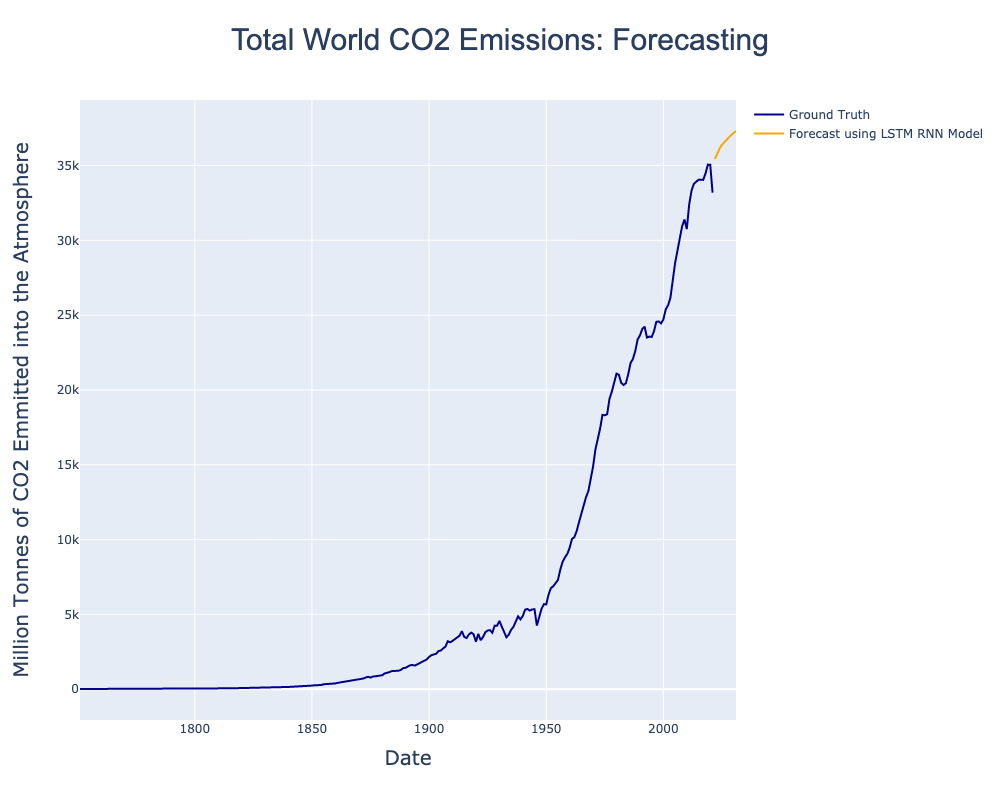

In [13]:
# Plotting the Results
fig = go.Figure()

fig.update_layout(
    width = 1000,
    height = 800,
    title = dict(
        text = 'Total World CO2 Emissions: Forecasting',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
)

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Million Tonnes of CO2 Emmitted into the Atmosphere',
    title_font = {'size': 20}
)

fig.add_trace(
    go.Scatter(
        x = df['date'],
        y = df['co2'],
        mode = 'lines',
        name = 'Ground Truth',
        marker = dict(
            color = 'darkblue',
            size = 15
        )
    )
)

fig.add_trace(
    go.Scatter(
        x = forecast['date'],
        y = forecast['co2_forecasted'],
        mode = 'lines',
        name = 'Forecast using LSTM RNN Model',
        marker = dict(
            color = 'orange',
            size = 15
        )
    )
)

fig.show('png')

# 3. Performance of an ARIMA Model
- This sections presents the data preparation (sequencing), model reproduction and forecasting for the ARIMA Model
- Is my understanding that Statsmodels has a bug when exporting/importing a model. For simplicity, and considering that the ARIMA Model is fast to train, I will just reproduce the best model
- If interested in the training and tuning of the ARIMA Model please refer to Models > ARIMA_Model.ipynb

## 3.1 Reproduce Best Arima Model

In [14]:
# Reproduce Best Arima Model
df_ar = df.copy()

# Set the index as date
df_ar.set_index('date', inplace = True)

# Use of a log transform: Log(co2)
df_ar['logco2'] = np.log(df_ar['co2'])
df_ar.tail()

,co2,logco2
date,,
2016-12-31,34035.382642,10.435156
2017-12-31,34471.811135,10.447897
2018-12-31,35058.007096,10.464759
2019-12-31,35049.914574,10.464528
2020-12-31,33185.793122,10.409877


In [15]:
# ARIMA Model
best_arima = sm.tsa.arima.ARIMA(endog = df_ar['logco2'], order = (1,1,1))
best_arima_fit = best_arima.fit()
print(best_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 logco2   No. Observations:                  271
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 415.919
Date:                Mon, 10 Oct 2022   AIC                           -825.838
Time:                        20:46:54   BIC                           -815.043
Sample:                    12-31-1750   HQIC                          -821.503
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9976      0.004    280.907      0.000       0.991       1.005
ma.L1         -0.9668      0.016    -58.918      0.000      -0.999      -0.935
sigma2         0.0027      0.000     23.737      0.0

## 3.2 Forecasting with ARIMA Model
- The goal is to forecast the next 10 years (starting 2021) using the reproduced ARIMA Model 

In [22]:
# Forecasting: 10 perdios (from 2021 to 2030)
# Remember that the data is here transformed as logarithm
forecast_int = best_arima_fit.get_forecast(steps = 10, alpha=0.05)
forecast_val = best_arima_fit.forecast(steps = 10, alpha=0.05)
forecast_int_val = forecast_int.conf_int()
forecast_val = np.exp(forecast_val)
forecast_val.tail(10)

2021-12-31    33690.107543
2022-12-31    34200.838783
2023-12-31    34718.049653
2024-12-31    35241.803330
2025-12-31    35772.163362
2026-12-31    36309.193658
2027-12-31    36852.958499
2028-12-31    37403.522527
2029-12-31    37960.950750
2030-12-31    38525.308539
Freq: A-DEC, Name: predicted_mean, dtype: float64

In [29]:
forecast_val.values

array([33690.1075426 , 34200.83878269, 34718.04965259, 35241.80333041,
       35772.16336162, 36309.19365842, 36852.958499  , 37403.52252676,
       37960.95074959, 38525.30853898])

## 3.3 ARIMA Results: Forecasting for the Next 10 Years

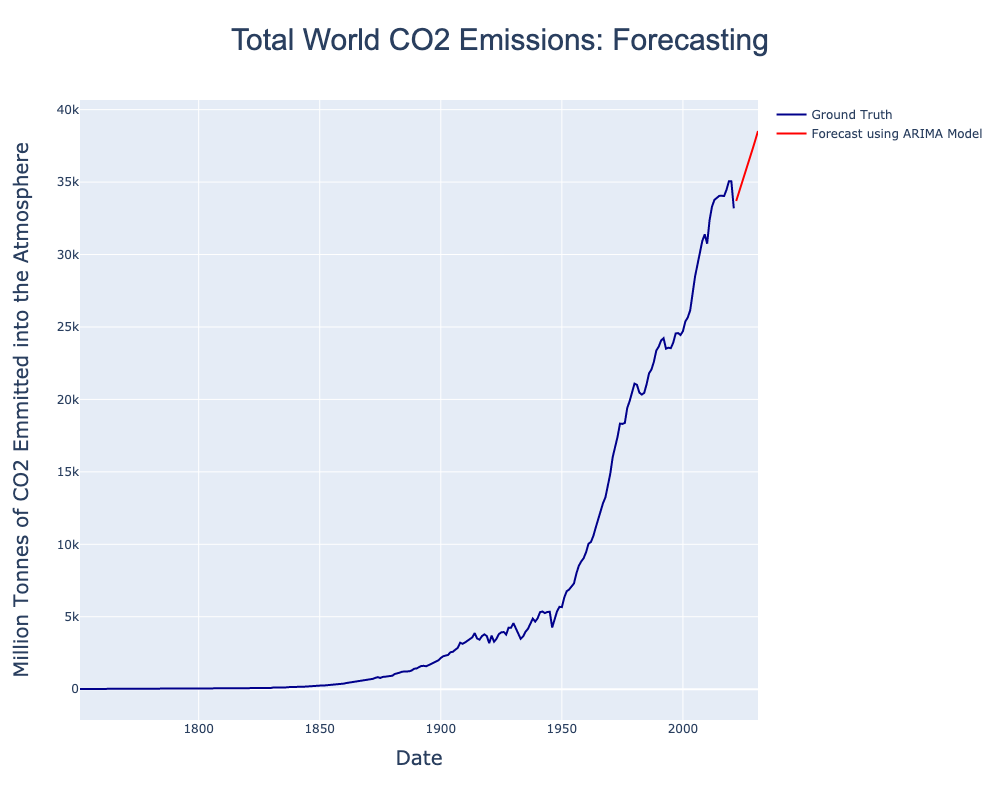

In [30]:
# Plotting the Results
fig = go.Figure()

fig.update_layout(
    width = 1000,
    height = 800,
    title = dict(
        text = 'Total World CO2 Emissions: Forecasting',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
)

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Million Tonnes of CO2 Emmitted into the Atmosphere',
    title_font = {'size': 20}
)

fig.add_trace(
    go.Scatter(
        x = df['date'],
        y = df['co2'],
        mode = 'lines',
        name = 'Ground Truth',
        marker = dict(
            color = 'darkblue',
            size = 15
        )
    )
)

fig.add_trace(
    go.Scatter(
        x = forecast_val.index,
        y = forecast_val.values,
        mode = 'lines',
        name = 'Forecast using ARIMA Model',
        marker = dict(
            color = 'red',
            size = 15
        )
    )
)

fig.show('png')

# 4. Forecasting Comparison: ARIMA vs. LSTM Model

In [32]:
# Plotting the Results
fig = go.Figure()

fig.update_layout(
    width = 1000,
    height = 800,
    title = dict(
        text = 'Total World CO2 Emissions Forecasting: ARIMA vs. LSTM Models',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
)

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Million Tonnes of CO2 Emmitted into the Atmosphere',
    title_font = {'size': 20}
)

fig.add_trace(
    go.Scatter(
        x = df['date'],
        y = df['co2'],
        mode = 'lines',
        name = 'Ground Truth',
        marker = dict(
            color = 'darkblue',
            size = 15
        )
    )
)

fig.add_trace(
    go.Scatter(
        x = forecast['date'],
        y = forecast['co2_forecasted'],
        mode = 'lines',
        name = 'Forecast using LSTM RNN Model',
        marker = dict(
            color = 'orange',
            size = 15
        )
    )
)

fig.add_trace(
    go.Scatter(
        x = forecast_val.index,
        y = forecast_val.values,
        mode = 'lines',
        name = 'Forecast using ARIMA Model',
        marker = dict(
            color = 'red',
            size = 15
        )
    )
)

fig.show()

## Final Discussion
- Clearly, both models show an upward trend
- While the LSTM Model exhibits a deceleration over time in the behavior of the CO2 Emissions, the ARIMA Model exhibits basically a constant (but high) rate of emission
- According to an [IEA article](https://www.iea.org/news/global-co2-emissions-rebounded-to-their-highest-level-in-history-in-2021) the cumulated World's CO2 Emissions in 2021 were 36.3 Billion Tonnes. Considering this:
    - The LSTM Model forecasts 35.4 Billion Tonnes for 2021, which underestimates the real value by 2.5%
    - The ARIMA Model forecasts 33.7 Billion Tonnes for 2021, which underestimates the real value by 7.2%
- According to the information give by the [IEA article](https://www.iea.org/news/global-co2-emissions-rebounded-to-their-highest-level-in-history-in-2021), the LSTM Model would be more precise into forecasting the actual emissions for 2021. Nonetheless, the ARIMA Model starts its prediction after the decrease in emissions due to the pandemic, an therefore might be unaccurate.
- Although the LSTM Model shows more precision when compared to the 2021 declared emissions, there are practical differences between both models that are worth discussing:
    - The training process of an ARIMA Model is extremely fast. This in comparison with the training and tuning process of the LSTM Model.
    - When the availability of data, computational resources and time is restricted, an ARIMA Model is a good way of providing good overall forecasting results.
    - When the availability of data, computational resources and time is more relaxed, a LSTM Model can deliver more precise results when needed.
- Both results are concerning, and should give us a reality check of the importance of our consumption behavior and habits towards the environment.